In [1]:
# The notebook where we analyze the ICD-10 codes 

from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

import src.metrics as metrics
import wandb
from src.settings import (
    ID_COLUMN,
    MODEL_NAMES,
    PROJECT,
    TARGET_COLUMN,
    EXPERIMENT_DIR,
)
from prepare_data.utils import load_gz_file_into_df
from reports.utils import get_db
from reports.wandb_utils import get_best_runs


sns.set_theme("paper", style="whitegrid", palette="colorblind", font_scale=1.5)


def one_hot(
    targets: list[list[str]], number_of_classes: int, target2index: dict[str, int]
) -> torch.Tensor:
    output_tensor = torch.zeros((len(targets), number_of_classes))
    for idx, case in enumerate(targets):
        for target in case:
            if target in target2index:
                output_tensor[idx, target2index[target]] = 1
    return output_tensor.long()


def load_predictions(
    run_id: str, split: str = "val"
) -> tuple[dict[str, torch.Tensor], str, int]:
    predictions = pd.read_feather(
        EXPERIMENT_DIR / run_id / f"predictions_{split}.feather"
    )

    predictions[TARGET_COLUMN] = predictions[TARGET_COLUMN].apply(
        lambda x: x.tolist()
    )  # convert from numpy array to list
    targets = predictions[[TARGET_COLUMN]]
    ids = predictions[ID_COLUMN].to_list()
    unique_targets = list(set.union(*targets[TARGET_COLUMN].apply(set)))
    logits = predictions[unique_targets]
    target2index = {target: idx for idx, target in enumerate(unique_targets)}
    number_of_classes = len(target2index)

    # Mapping from target to index and vice versa
    targets_torch = one_hot(
        targets[TARGET_COLUMN].to_list(), number_of_classes, target2index
    )  # one_hot encoding of targets
    logits_torch = torch.tensor(logits.values)
    code_names = logits.columns.tolist()

    return logits_torch, targets_torch, ids, number_of_classes, code_names


def get_target_counts(targets: list[list[str]]) -> dict[str, int]:
    counts = {}
    for case in targets:
        for target in case:
            if target in counts:
                counts[target] += 1
            else:
                counts[target] = 1
    return counts


def plot_metric_vs_target_counts(
    metric_name: str,
    run: wandb.apis.public.Run,
    target_counts: dict[str, int],
) -> None:
    model_name = run.config["model"]["name"]

    if model_name in MODEL_NAMES:
        model_name = MODEL_NAMES[model_name]

    db = get_db(run.id)

    logits, targets, ids, number_of_classes, code_names = load_predictions(
        run.id, "test"
    )
    metric_class = getattr(metrics, metric_name)
    metric = metric_class(
        number_of_classes=number_of_classes, average=None, threshold=db
    )
    cases = {"logits": logits, "targets": targets}
    metric.update(cases)
    metric_name = metric_name.lower()

    results_df = pd.DataFrame({metric_name: metric.compute().numpy()}, index=code_names)
    results_df["code"] = code_names
    results_df["counts"] = results_df.index.map(lambda x: target_counts.get(x, 0))
    results_df = results_df[results_df["counts"] > 0]
    results_df["counts_log"] = np.log10(results_df["counts"])
    results_df["model"] = model_name
    print(f"{model_name}: ALL")
    print(
        f"Pearson Correlation: {results_df[['counts_log', metric_name]].corr()[metric_name]['counts_log']}"
    )
    print(
        f"Spearman Correlation: {results_df[['counts_log', metric_name]].corr(method='spearman')[metric_name]['counts_log']}"
    )

    return results_df


mimiciv_icd10 = pd.read_feather("path/to/mimiciv_icd10.feather")
mimiciv_icd10_splits = pd.read_feather(
    "path/to/mimiciv_icd10_splits.feather"
)
mimiciv_icd10 = mimiciv_icd10.merge(
    mimiciv_icd10_splits[[ID_COLUMN, "split"]], on=ID_COLUMN, how="left"
)

code_system2code_name = defaultdict(list)
code_columns = ["icd10_diag", "icd10_proc"]
for col in code_columns:
    code_system2code_name[col] = set(mimiciv_icd10[col].explode().unique().tolist())

code_name2code_system = defaultdict(str)
for code_system, code_names in code_system2code_name.items():
    for code_name in code_names:
        code_name2code_system[code_name] = code_system

train_mimiciv_icd10 = mimiciv_icd10[mimiciv_icd10["split"] == "train"]

target_counts_mimiciv_icd10 = get_target_counts(
    train_mimiciv_icd10[TARGET_COLUMN].tolist()
)


sweep_id = "46ah61d0"
run_mimiciv_icd10 = get_best_runs(
    PROJECT,
    "f1_micro",
    {
        "Sweep": {"$regex": f"{sweep_id}"},
        "State": "finished",
        "config.model.name": "PLMICD",
    },
)["PLMICD"]


df = plot_metric_vs_target_counts(
    "F1Score", run_mimiciv_icd10, target_counts_mimiciv_icd10
)
df["code_system"] = df["code"].map(lambda x: code_name2code_system[x])

Best F1: 0.5893 at DB: 0.3636
PLM-ICD: ALL
Pearson Correlation: 0.5047995977994552
Spearman Correlation: 0.548916155495209


In [2]:
df_diag = df[df["code_system"] == "icd10_diag"]
df_proc = df[df["code_system"] == "icd10_proc"]
df_diag["category"] = df_diag["code"].map(lambda x: x[:3])
df_diag["chapter"] = df_diag["code"].map(lambda x: x[0])

diag_description = load_gz_file_into_df(
    Path("path/to/d_icd_diagnoses.csv.gz")
)
icd10_diag_description = diag_description[diag_description["icd_version"] == 10]
icd10_diag_description["icd_code"] = (
    icd10_diag_description["icd_code"].str[:3]
    + "."
    + icd10_diag_description["icd_code"].str[3:]
)
icd10_diag_description.loc[
    icd10_diag_description["icd_code"].str.len() == 4, "icd_code"
] = icd10_diag_description.loc[
    icd10_diag_description["icd_code"].str.len() == 4, "icd_code"
].str[
    :3
]
df_diag.loc[df_diag["code"].str.len() == 4, "code"] = df_diag.loc[
    df_diag["code"].str.len() == 4, "code"
].str[:3]

proc_description = load_gz_file_into_df(
    Path("path/to/d_icd_procedures.csv.gz")
)
icd10_proc_description = proc_description[proc_description["icd_version"] == 10]


code2name = (
    icd10_diag_description[["icd_code", "long_title"]]
    .set_index("icd_code")
    .to_dict()["long_title"]
    | icd10_proc_description[["icd_code", "long_title"]]
    .set_index("icd_code")
    .to_dict()["long_title"]
)
code2chronic = (
    icd10_diag_description[["icd_code", "chronic"]]
    .set_index("icd_code")
    .to_dict()["chronic"]
)

/tmp/ipykernel_10382/3369682166.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diag["category"] = df_diag["code"].map(lambda x: x[:3])
/tmp/ipykernel_10382/3369682166.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diag["chapter"] = df_diag["code"].map(lambda x: x[0])


In [3]:
df_diag["code_name"] = df_diag["code"].map(lambda x: code2name.get(x))
df_diag["category_name"] = df_diag["category"].map(lambda x: code2name[x])
df_proc["code_name"] = df_proc["code"].map(lambda x: code2name.get(x))

/tmp/ipykernel_10382/2135332897.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diag["code_name"] = df_diag["code"].map(lambda x: code2name.get(x))
/tmp/ipykernel_10382/2135332897.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diag["category_name"] = df_diag["category"].map(lambda x: code2name[x])
/tmp/ipykernel_10382/2135332897.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [4]:
chapter2name = {
    "A00-B99": "Certain infectious and parasitic diseases",
    "C00-D49": "Neoplasms",
    "D50-D89": "Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism",
    "E00-E89": "Endocrine, nutritional and metabolic diseases",
    "F01-F99": "Mental, Behavioral and Neurodevelopmental disorders",
    "G00-G99": "Diseases of the nervous system",
    "H00-H59": "Diseases of the eye and adnexa",
    "H60-H95": "Diseases of the ear and mastoid process",
    "I00-I99": "Diseases of the circulatory system",
    "J00-J99": "Diseases of the respiratory system",
    "K00-K95": "Diseases of the digestive system",
    "L00-L99": "Diseases of the skin and subcutaneous tissue",
    "M00-M99": "Diseases of the musculoskeletal system and connective tissue",
    "N00-N99": "Diseases of the genitourinary system",
    "O00-O9A": "Pregnancy, childbirth and the puerperium",
    "P00-P96": "Certain conditions originating in the perinatal period",
    "Q00-Q99": "Congenital malformations, deformations and chromosomal abnormalities",
    "R00-R99": "Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified",
    "S00-T88": "Injury, poisoning and certain other consequences of external causes",
    "U00-U85": "Codes for special purposes",
    "V00-Y99": "External causes of morbidity",
    "Z00-Z99": "Factors influencing health status and contact with health services",
}

name2chapter = {v: k for k, v in chapter2name.items()}

letter2name = {
    "A": "Certain infectious and parasitic diseases",
    "B": "Certain infectious and parasitic diseases",
    "C": "Neoplasms",
    "E": "Endocrine, nutritional and metabolic diseases",
    "F": "Mental, Behavioral and Neurodevelopmental disorders",
    "G": "Diseases of the nervous system",
    "I": "Diseases of the circulatory system",
    "J": "Diseases of the respiratory system",
    "K": "Diseases of the digestive system",
    "L": "Diseases of the skin and subcutaneous tissue",
    "M": "Diseases of the musculoskeletal system and connective tissue",
    "N": "Diseases of the genitourinary system",
    "O": "Pregnancy, childbirth and the puerperium",
    "P": "Certain conditions originating in the perinatal period",
    "Q": "Congenital malformations, deformations and chromosomal abnormalities",
    "R": "Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified",
    "S": "Injury, poisoning and certain other consequences of external causes",
    "T": "Injury, poisoning and certain other consequences of external causes",
    "U": "Codes for special purposes",
    "V": "External causes of morbidity",
    "W": "External causes of morbidity",
    "Y": "External causes of morbidity",
    "X": "External causes of morbidity",
    "Z": "Factors influencing health status and contact with health services",
}


def difficult_chapters(x: str) -> str:
    if "D" in x:
        if "3A" in x:
            return "Neoplasms"
        if int(x[1:]) < 50:
            return "Neoplasms"
        else:
            return "Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism"

    if "H" in x:
        if int(x[1:]) < 60:
            return "Diseases of the eye and adnexa"
        else:
            return "Diseases of the ear and mastoid process"


df_diag["chapter_name"] = df_diag["chapter"].map(lambda x: letter2name.get(x))
df_diag.loc[df_diag["chapter_name"].isna(), "chapter_name"] = df_diag.loc[
    df_diag["chapter_name"].isna(), "category"
].apply(lambda x: difficult_chapters(x))
df_diag["chapter_name"].value_counts()
df_diag["real_chapter"] = df_diag["chapter_name"].map(lambda x: name2chapter[x])

/tmp/ipykernel_10382/3001766700.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diag["chapter_name"] = df_diag["chapter"].map(lambda x: letter2name.get(x))
/tmp/ipykernel_10382/3001766700.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diag["real_chapter"] = df_diag["chapter_name"].map(lambda x: name2chapter[x])


In [5]:
no_detection = df_diag[df_diag["f1score"] == 0]
detection = df_diag[df_diag["f1score"] > 0]
bad = df_diag[df_diag["f1score"] < 0.2]
excellent = df_diag[df_diag["f1score"] > 0.6]

bad_common = bad[bad["counts"] > 100]
excellent_common = excellent[excellent["counts"] > 100]
no_detection_common = no_detection[no_detection["counts"] > 100]
detection_common = detection[detection["counts"] > 100]

bad_rare = bad[bad["counts"] < 100]
excellent_rare = excellent[excellent["counts"] < 100]
no_detection_rare = no_detection[no_detection["counts"] < 100]
detection_rare = detection[detection["counts"] < 100]

common = df_diag[df_diag["counts"] > 100]
rare = df_diag[df_diag["counts"] < 100]

In [10]:
no_detection_common.sort_values(
    "counts", ascending=False
).head(40)[["code", "code_name", "category_name", "chapter_name", "counts", "chronic"]]

,code,code_name,category_name,chapter_name,counts,chronic
Z23.,Z23,Encounter for immunization,Encounter for immunization,Factors influencing health status and contact ...,4233,9
Z79.82,Z79.82,Long term (current) use of aspirin,Long term (current) drug therapy,Factors influencing health status and contact ...,2044,9
Z72.0,Z72.0,Tobacco use,Problems related to lifestyle,Factors influencing health status and contact ...,1914,9
E78.0,E78.0,Pure hypercholesterolemia,Disorders of lipoprotein metabolism and other ...,"Endocrine, nutritional and metabolic diseases",1081,1
Y92.89,Y92.89,Other specified places as the place of occurre...,Place of occurrence of the external cause,External causes of morbidity,876,9
F17.200,F17.200,"Nicotine dependence, unspecified, uncomplicated",Nicotine dependence,"Mental, Behavioral and Neurodevelopmental diso...",833,1
Z79.899,Z79.899,Other long term (current) drug therapy,Long term (current) drug therapy,Factors influencing health status and contact ...,696,9
F41.8,F41.8,Other specified anxiety disorders,Other anxiety disorders,"Mental, Behavioral and Neurodevelopmental diso...",596,1
Y92.019,Y92.019,Unspecified place in single-family (private) h...,Place of occurrence of the external cause,External causes of morbidity,494,9
E78.49,E78.49,Other hyperlipidemia,Disorders of lipoprotein metabolism and other ...,"Endocrine, nutritional and metabolic diseases",452,1


/tmp/ipykernel_10382/1733749020.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diag["f1_sum"] = df_diag["f1score"]*df_diag["counts"]


Text(0.5, 0, 'F1 Micro')

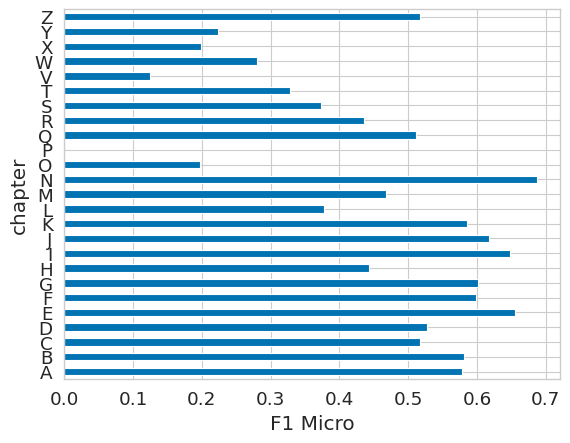

In [14]:
# F1 micro per chapter
df_diag["f1_sum"] = df_diag["f1score"] * df_diag["counts"]
df_diag.groupby("chapter").apply(
    lambda row: row["f1_sum"].sum() / row["counts"].sum()
).plot.barh()
plt.xlabel("F1 Micro")

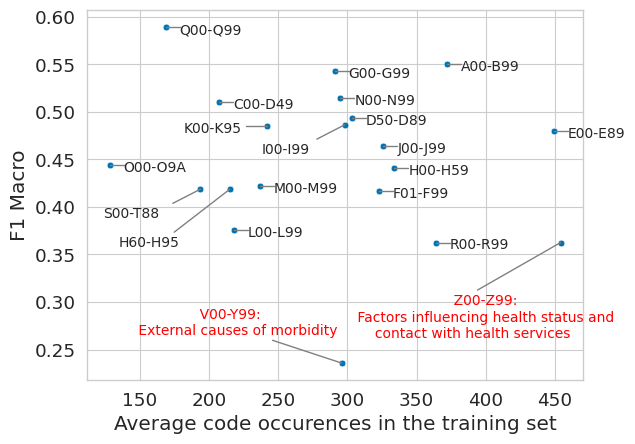

In [15]:
# Plot the F1 score for each chapter
fig, ax = plt.subplots()
df = df_diag[df_diag["counts"] > 100]
counts = df.groupby("real_chapter").counts.median()
f1 = df.groupby("real_chapter").f1score.mean()
sns.scatterplot(x=counts, y=f1, ax=ax)
plt.xlabel("Average code occurences in the training set")
plt.ylabel("F1 Macro")

plt.rc("font", size=10)
for i, txt in enumerate(counts.index):
    txt_x = counts[i] + 10
    txt_y = f1[i] - 0.007

    if txt == "S00-T88":
        txt_x = counts[i] - 70
        txt_y = f1[i] - 0.03
        ax.annotate(txt, (txt_x, txt_y))
        ax.add_line(
            plt.Line2D(
                [counts[i], txt_x + 50],
                [f1[i], txt_y + 0.015],
                linestyle="-",
                linewidth=1,
                color="gray",
            )
        )
    elif txt == "H60-H95":
        txt_x = counts[i] - 80
        txt_y = f1[i] - 0.06
        ax.annotate(txt, (txt_x, txt_y))
        ax.add_line(
            plt.Line2D(
                [counts[i], txt_x + 40],
                [f1[i], txt_y + 0.015],
                linestyle="-",
                linewidth=1,
                color="gray",
            )
        )
    elif txt == "K00-K95":
        txt_x = counts[i] - 60
        ax.annotate(txt, (txt_x, txt_y))
        ax.add_line(
            plt.Line2D(
                [counts[i], txt_x + 45],
                [f1[i], txt_y + 0.007],
                linestyle="-",
                linewidth=1,
                color="gray",
            )
        )
    elif txt == "I00-I99":
        txt_x = counts[i] - 60
        txt_y = f1[i] - 0.03
        ax.annotate(txt, (txt_x, txt_y))
        ax.add_line(
            plt.Line2D(
                [counts[i], txt_x + 40],
                [f1[i], txt_y + 0.015],
                linestyle="-",
                linewidth=1,
                color="gray",
            )
        )
    elif txt == "I00-I99":
        txt_x = counts[i] - 30
        txt_y = f1[i] - 0.03
        ax.annotate(txt, (txt_x, txt_y))
        ax.add_line(
            plt.Line2D(
                [counts[i], txt_x + 30],
                [f1[i], txt_y + 0.01],
                linestyle="-",
                linewidth=1,
                color="gray",
            )
        )
    elif txt == "Z00-Z99":
        txt_x = counts[i] - 150
        txt_y = f1[i] - 0.1
        ax.annotate(
            "                       Z00-Z99:\n Factors influencing health status and\n     contact with health services",
            (txt_x, txt_y),
            color="red",
        )
        ax.add_line(
            plt.Line2D(
                [counts[i], txt_x + 90],
                [f1[i], txt_y + 0.05],
                linestyle="-",
                linewidth=1,
                color="gray",
            )
        )
    elif txt == "V00-Y99":
        txt_x = counts[i] - 150
        txt_y = f1[i] + 0.03
        ax.annotate(
            "               V00-Y99: \n External causes of morbidity",
            (txt_x, txt_y),
            color="red",
        )
        ax.add_line(
            plt.Line2D(
                [counts[i], txt_x + 100],
                [f1[i], txt_y - 0.006],
                linestyle="-",
                linewidth=1,
                color="gray",
            )
        )
    else:
        ax.annotate(txt, (txt_x, txt_y))
        ax.add_line(
            plt.Line2D(
                [counts[i], txt_x],
                [f1[i], txt_y + 0.007],
                linestyle="-",
                linewidth=1,
                color="gray",
            )
        )


plt.savefig(
    "files/images/chapters.png",
    dpi=400,
    bbox_inches="tight",
)

In [16]:
# Chapter name types
df["chapter_name"].value_counts()

Factors influencing health status and contact with health services                                     196
Diseases of the circulatory system                                                                     162
Diseases of the digestive system                                                                       127
Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified                125
Endocrine, nutritional and metabolic diseases                                                           94
Diseases of the musculoskeletal system and connective tissue                                            77
Injury, poisoning and certain other consequences of external causes                                     73
Neoplasms                                                                                               70
Mental, Behavioral and Neurodevelopmental disorders                                                     57
Diseases of the respiratory system   

Text(0.5, 0, 'Code occurences in the training')

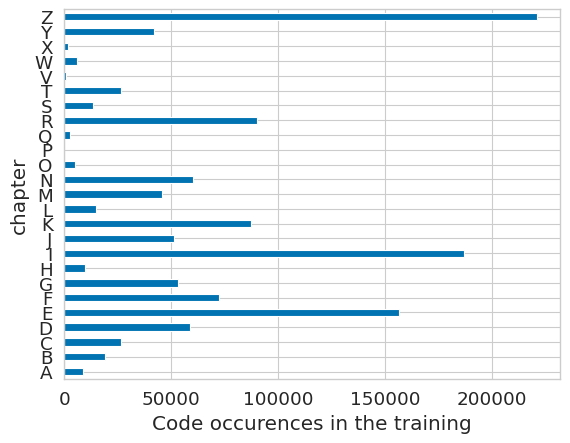

In [17]:
df_diag.groupby("chapter").counts.sum().plot.barh()
plt.xlabel("Code occurences in the training")

<AxesSubplot:ylabel='chapter'>

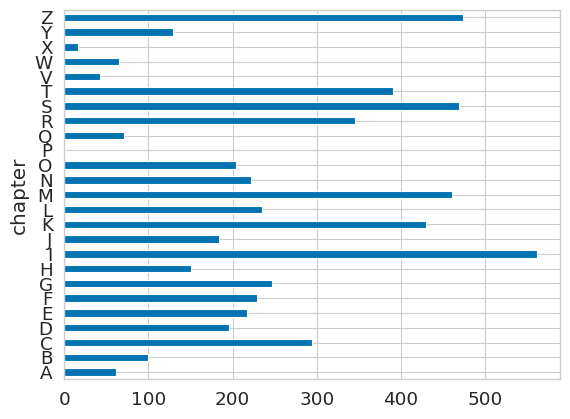

In [18]:
df_diag.groupby("chapter").apply(len).plot.barh()

In [20]:
# The absurdly specific Y92 codes
df_diag[df_diag["category"] == "Y92"]

,f1score,code,counts,counts_log,model,code_system,category,chapter,code_name,category_name,chronic,chapter_name,real_chapter,f1_sum
Y92.008,0.000000,Y92.008,217,2.336460,PLM-ICD,icd10_diag,Y92,Y,Other place in unspecified non-institutional (...,Place of occurrence of the external cause,9,External causes of morbidity,V00-Y99,0.000000
Y92.410,0.607407,Y92.410,518,2.714330,PLM-ICD,icd10_diag,Y92,Y,Unspecified street and highway as the place of...,Place of occurrence of the external cause,9,External causes of morbidity,V00-Y99,314.637029
Y92.530,0.000000,Y92.530,37,1.568202,PLM-ICD,icd10_diag,Y92,Y,Ambulatory surgery center as the place of occu...,Place of occurrence of the external cause,9,External causes of morbidity,V00-Y99,0.000000
Y92.830,0.000000,Y92.830,21,1.322219,PLM-ICD,icd10_diag,Y92,Y,Public park as the place of occurrence of the ...,Place of occurrence of the external cause,9,External causes of morbidity,V00-Y99,0.000000
Y92.214,0.000000,Y92.214,18,1.255273,PLM-ICD,icd10_diag,Y92,Y,College as the place of occurrence of the exte...,Place of occurrence of the external cause,9,External causes of morbidity,V00-Y99,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y92.010,0.000000,Y92.010,37,1.568202,PLM-ICD,icd10_diag,Y92,Y,Kitchen of single-family (private) house as th...,Place of occurrence of the external cause,9,External causes of morbidity,V00-Y99,0.000000
Y92.538,0.000000,Y92.538,85,1.929419,PLM-ICD,icd10_diag,Y92,Y,Other ambulatory health services establishment...,Place of occurrence of the external cause,9,External causes of morbidity,V00-Y99,0.000000
Y92.231,0.000000,Y92.231,67,1.826075,PLM-ICD,icd10_diag,Y92,Y,Patient bathroom in hospital as the place of o...,Place of occurrence of the external cause,9,External causes of morbidity,V00-Y99,0.000000
Y92.018,0.000000,Y92.018,324,2.510545,PLM-ICD,icd10_diag,Y92,Y,Other place in single-family (private) house a...,Place of occurrence of the external cause,9,External causes of morbidity,V00-Y99,0.000000


In [26]:
# Codes containing digits
df_diag[df_diag.code_name.str.contains(r"\d")].sort_values(
    "f1score", ascending=True
).head(60)

,f1score,code,counts,counts_log,model,code_system,category,chapter,code_name,category_name,chronic,chapter_name,real_chapter,f1_sum
L89.301,0.0,L89.301,8,0.903090,PLM-ICD,icd10_diag,L89,L,"Pressure ulcer of unspecified buttock, stage 1",Pressure ulcer,0,Diseases of the skin and subcutaneous tissue,L00-L99,0.0
L89.312,0.0,L89.312,50,1.698970,PLM-ICD,icd10_diag,L89,L,"Pressure ulcer of right buttock, stage 2",Pressure ulcer,1,Diseases of the skin and subcutaneous tissue,L00-L99,0.0
Z3A.35,0.0,Z3A.35,57,1.755875,PLM-ICD,icd10_diag,Z3A,Z,35 weeks gestation of pregnancy,Weeks of gestation,9,Factors influencing health status and contact ...,Z00-Z99,0.0
S22.078A,0.0,S22.078A,17,1.230449,PLM-ICD,icd10_diag,S22,S,"Other fracture of T9-T10 vertebra, initial enc...","Fracture of rib(s), sternum and thoracic spine",0,"Injury, poisoning and certain other consequenc...",S00-T88,0.0
L89.892,0.0,L89.892,41,1.612784,PLM-ICD,icd10_diag,L89,L,"Pressure ulcer of other site, stage 2",Pressure ulcer,1,Diseases of the skin and subcutaneous tissue,L00-L99,0.0
L89.894,0.0,L89.894,10,1.000000,PLM-ICD,icd10_diag,L89,L,"Pressure ulcer of other site, stage 4",Pressure ulcer,1,Diseases of the skin and subcutaneous tissue,L00-L99,0.0
E10.628,0.0,E10.628,19,1.278754,PLM-ICD,icd10_diag,E10,E,Type 1 diabetes mellitus with other skin compl...,Type 1 diabetes mellitus,1,"Endocrine, nutritional and metabolic diseases",E00-E89,0.0
E10.39,0.0,E10.39,23,1.361728,PLM-ICD,icd10_diag,E10,E,Type 1 diabetes mellitus with other diabetic o...,Type 1 diabetes mellitus,1,"Endocrine, nutritional and metabolic diseases",E00-E89,0.0
R29.705,0.0,R29.705,39,1.591065,PLM-ICD,icd10_diag,R29,R,NIHSS score 5,Other symptoms and signs involving the nervous...,9,"Symptoms, signs and abnormal clinical and labo...",R00-R99,0.0
S22.068A,0.0,S22.068A,10,1.000000,PLM-ICD,icd10_diag,S22,S,"Other fracture of T7-T8 thoracic vertebra, ini...","Fracture of rib(s), sternum and thoracic spine",0,"Injury, poisoning and certain other consequenc...",S00-T88,0.0


In [58]:
# Tobacco codes
df_diag[
    df_diag["code"].isin(
        [
            "Z72.0",
            "Z87.891",
            "F17.210",
            "F17.200",
            "F17.290",
            "F17.211",
            "F17.220",
            "F17.213",
            "F17.219",
            "F17.218",
        ]
    )
].sort_values("counts", ascending=False)[["code_name", "counts", "f1score"]]

,code_name,counts,f1score
Z87.891,Personal history of nicotine dependence,26427,0.532035
F17.210,"Nicotine dependence, cigarettes, uncomplicated",8486,0.510016
Z72.0,Tobacco use,1914,0.000000
F17.200,"Nicotine dependence, unspecified, uncomplicated",833,0.000000
F17.290,"Nicotine dependence, other tobacco product, un...",363,0.000000
F17.211,"Nicotine dependence, cigarettes, in remission",44,0.000000
F17.220,"Nicotine dependence, chewing tobacco, uncompli...",43,0.000000
F17.213,"Nicotine dependence, cigarettes, with withdrawal",17,0.000000
F17.219,"Nicotine dependence, cigarettes, with unspecif...",16,0.000000
F17.218,"Nicotine dependence, cigarettes, with other ni...",10,0.000000
